<a href="https://colab.research.google.com/github/Varshiga-tn7/Projects/blob/main/Expiry_Based_Dynamic_Pricing__MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Installation of required libraries***

In [12]:
# Install required libraries
!pip install tensorflow pandas numpy scikit-learn matplotlib seaborn kaggle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from datetime import datetime


### ***Loading and Displaying Top 5 Rows***

In [13]:
# Load Supermarket Sales Dataset from GitHub
df = pd.read_csv("/content/supermarket_sales - Sheet1.csv")

# Display first 5 rows
df.head()


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


Preprocessing: Date Conversion & Shelf Life Calculation

In [15]:
# Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Assign shelf life based on product type (simulated values)
shelf_life_dict = {
    "Health and beauty": 180,  # 6 months
    "Electronic accessories": 365,  # 1 year
    "Home and lifestyle": 240,  # 8 months
    "Sports and travel": 300,  # 10 months
    "Food and beverages": 90,  # 3 months
    "Fashion accessories": 150  # 5 months
}

# Assign shelf life based on product line
df["Shelf_Life"] = df["Product line"].map(shelf_life_dict)

# Simulate expiry date by adding shelf life to transaction date
df["Expiry_Date"] = df["Date"] + pd.to_timedelta(df["Shelf_Life"], unit='D')

#today = datetime.today()  -> Since data has old values we use the latest transaction as the cuurent date
# Get the latest transaction date in the dataset
latest_transaction_date = df["Date"].max()

# Calculate Days to Expire correctly (Expiry Date - Latest Transaction Date)
df["Days_to_Expire"] = (df["Expiry_Date"] - latest_transaction_date).dt.days

# Ensure there are no negative values (set expired items to 0)
df["Days_to_Expire"] = df["Days_to_Expire"].apply(lambda x: max(x, 0))

# Display results
df[["Product line", "Date", "Expiry_Date", "Days_to_Expire"]].head(10)


,Product line,Date,Expiry_Date,Days_to_Expire
0,Health and beauty,2019-01-05,2019-07-04,96
1,Electronic accessories,2019-03-08,2020-03-07,343
2,Home and lifestyle,2019-03-03,2019-10-29,213
3,Health and beauty,2019-01-27,2019-07-26,118
4,Sports and travel,2019-02-08,2019-12-05,250
5,Electronic accessories,2019-03-25,2020-03-24,360
6,Electronic accessories,2019-02-25,2020-02-25,332
7,Home and lifestyle,2019-02-24,2019-10-22,206
8,Health and beauty,2019-01-10,2019-07-09,101
9,Food and beverages,2019-02-20,2019-05-21,52


### ***Encoding : Assinging Variable for Ease of Use***

In [16]:
# Encode categorical variables
label_encoder = LabelEncoder()
df["Product_line_encoded"] = label_encoder.fit_transform(df["Product line"])
df["Branch_encoded"] = label_encoder.fit_transform(df["Branch"])
df["City_encoded"] = label_encoder.fit_transform(df["City"])
df["Customer_type_encoded"] = label_encoder.fit_transform(df["Customer type"])
df["Payment_encoded"] = label_encoder.fit_transform(df["Payment"])

df.head()


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,...,gross income,Rating,Shelf_Life,Expiry_Date,Days_to_Expire,Product_line_encoded,Branch_encoded,City_encoded,Customer_type_encoded,Payment_encoded
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,...,26.1415,9.1,180,2019-07-04,96,3,0,2,0,2
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,...,3.8200,9.6,365,2020-03-07,343,0,2,1,1,0
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,...,16.2155,7.4,240,2019-10-29,213,4,0,2,1,1
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,...,23.2880,8.4,180,2019-07-26,118,3,0,2,0,2
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,...,30.2085,5.3,300,2019-12-05,250,5,0,2,1,2


### ***Feature Scaling using StandardScaler***

In [17]:
from sklearn.preprocessing import StandardScaler

# Select numerical features for scaling
features = ["Product_line_encoded", "Branch_encoded", "Unit price", "Quantity", "Days_to_Expire"]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

df_scaled.head()


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,...,gross income,Rating,Shelf_Life,Expiry_Date,Days_to_Expire,Product_line_encoded,Branch_encoded,City_encoded,Customer_type_encoded,Payment_encoded
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,0.718160,0.509930,26.1415,548.9715,...,26.1415,9.1,180,2019-07-04,-0.823692,0.319617,-1.208970,2,0,2
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,-1.525303,-0.174540,3.8200,80.2200,...,3.8200,9.6,365,2020-03-07,1.720285,-1.430109,1.238338,1,1,0
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,-0.352781,0.509930,16.2155,340.5255,...,16.2155,7.4,240,2019-10-29,0.381349,0.902859,-1.208970,2,1,1
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,0.096214,0.852165,23.2880,489.0480,...,23.2880,8.4,180,2019-07-26,-0.597103,0.319617,-1.208970,2,0,2
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,1.156959,0.509930,30.2085,634.3785,...,30.2085,5.3,300,2019-12-05,0.762431,1.486101,-1.208970,2,1,2


### ***Define Target Variable (Discount Prediction)***

In [18]:
df_scaled["Discount_Percentage"] = np.where(df_scaled["Days_to_Expire"] <= 30,
                                            np.random.uniform(10, 50, df_scaled.shape[0]),
                                            np.random.uniform(0, 10, df_scaled.shape[0]))

# Display data
df_scaled[["Product line", "Days_to_Expire", "Discount_Percentage"]].head()

,Product line,Days_to_Expire,Discount_Percentage
0,Health and beauty,-0.823692,28.998482
1,Electronic accessories,1.720285,46.905144
2,Home and lifestyle,0.381349,31.848661
3,Health and beauty,-0.597103,38.700117
4,Sports and travel,0.762431,43.453693


### ***Train MLP with Different Learning Functions***

In [29]:
# Import Huber loss
from tensorflow.keras.losses import Huber

# Function to Train MLP with Different Learning Functions
def train_mlp(activation, loss, name):
    model = Sequential([
        Dense(32, activation=activation),
        Dense(16, activation=activation),
        Dense(1, activation="linear")  # Linear for regression models
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss=loss, metrics=["mae"])
    model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0, validation_data=(X_test, y_test))

    # Predict Discounts
    y_pred = model.predict(X).flatten()
    df_scaled[f"Predicted_Discount_{name}"] = y_pred.round(2)

# Train with Different Learning Functions
train_mlp("relu", "mse", "Standard")   # Standard MLP (MSE Loss)
train_mlp("relu", Huber(delta=1.0), "Robust")  # Robust MLP (Huber Loss)
train_mlp("softmax", "categorical_crossentropy", "Probability")  # Probability-based (Softmax Output)
train_mlp("sigmoid", "binary_crossentropy", "Binary")  # Binary Classification (Sigmoid Output)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(8, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(8, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### ***Compare Performance of Learning Functions***

In [30]:
# Compare MAE for different learning functions
results = {
    "Standard MLP": mean_absolute_error(y, df_scaled["Predicted_Discount_Standard"]),
    "Robust MLP": mean_absolute_error(y, df_scaled["Predicted_Discount_Robust"]),
    "Probability-Based MLP": mean_absolute_error(y, df_scaled["Predicted_Discount_Probability"]),
    "Binary Classification MLP": mean_absolute_error(y, df_scaled["Predicted_Discount_Binary"])
}

results_df = pd.DataFrame(results, index=["MAE"]).T
print(results_df)


                                 MAE
Standard MLP                9.539875
Robust MLP                 10.038722
Probability-Based MLP      30.278522
Binary Classification MLP  30.605672


## ***Visualization : Comparison of Actual vs Predicted Discounts***




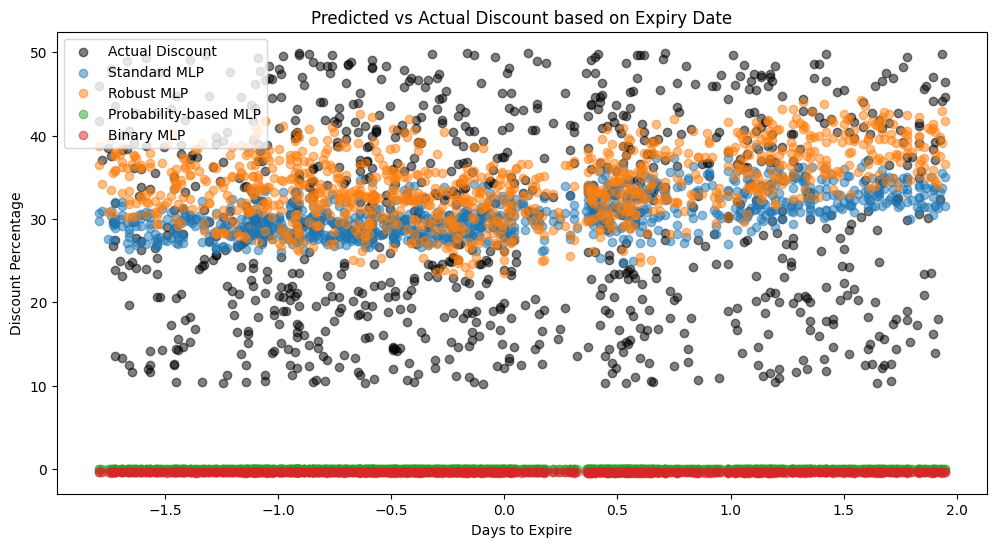

In [32]:
plt.figure(figsize=(12,6))

plt.scatter(df_scaled["Days_to_Expire"], df_scaled["Discount_Percentage"], label="Actual Discount", alpha=0.5, color="black")
plt.scatter(df_scaled["Days_to_Expire"], df_scaled["Predicted_Discount_Standard"], label="Standard MLP", alpha=0.5)
plt.scatter(df_scaled["Days_to_Expire"], df_scaled["Predicted_Discount_Robust"], label="Robust MLP", alpha=0.5)
plt.scatter(df_scaled["Days_to_Expire"], df_scaled["Predicted_Discount_Probability"], label="Probability-based MLP", alpha=0.5)
plt.scatter(df_scaled["Days_to_Expire"], df_scaled["Predicted_Discount_Binary"], label="Binary MLP", alpha=0.5)

plt.xlabel("Days to Expire")
plt.ylabel("Discount Percentage")
plt.title("Predicted vs Actual Discount based on Expiry Date")
plt.legend()
plt.show()


## ***Exporting Results***

In [33]:
# Save predictions to CSV
df_scaled.to_csv("Predicted_Discounts.csv", index=False)

# Download file
from google.colab import files
files.download("Predicted_Discounts.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>